In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [2]:
train = pd.read_csv('train.csv')
train = train.sample(n=5000, random_state=42).reset_index(drop=True)
test = pd.read_csv('test.csv')
print("Train shape:", train.shape)
print(train.info())
print(train['Exited'].value_counts(normalize=True))

Train shape: (5000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5000 non-null   int64  
 1   CustomerId       5000 non-null   int64  
 2   Surname          5000 non-null   object 
 3   CreditScore      5000 non-null   int64  
 4   Geography        5000 non-null   object 
 5   Gender           5000 non-null   object 
 6   Age              5000 non-null   float64
 7   Tenure           5000 non-null   int64  
 8   Balance          5000 non-null   float64
 9   NumOfProducts    5000 non-null   int64  
 10  HasCrCard        5000 non-null   float64
 11  IsActiveMember   5000 non-null   float64
 12  EstimatedSalary  5000 non-null   float64
 13  Exited           5000 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 547.0+ KB
None
Exited
0    0.7822
1    0.2178
Name: proportion, dtype: float64


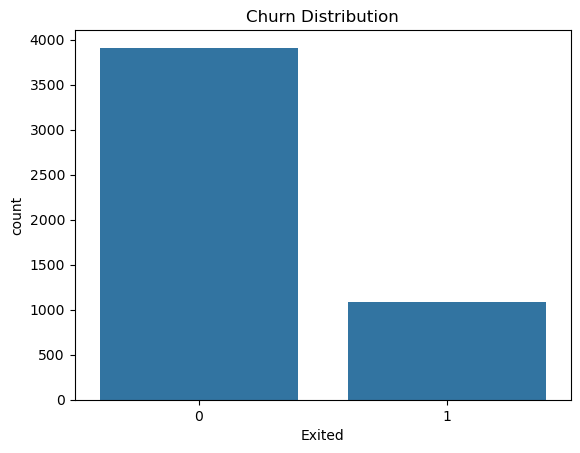

In [3]:
sns.countplot(x='Exited', data=train)
plt.title('Churn Distribution')
plt.show()

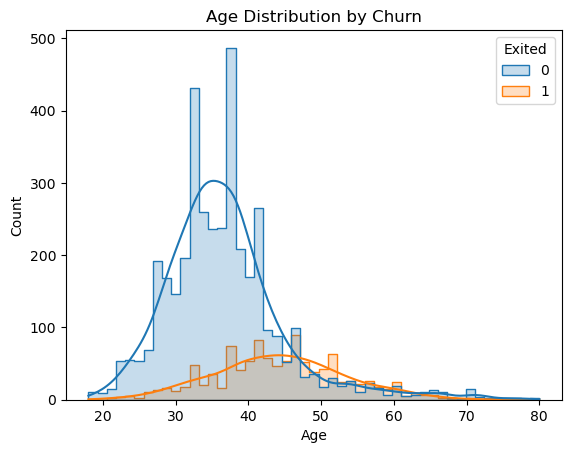

In [4]:
sns.histplot(data=train, x='Age', hue='Exited', kde=True, element='step')
plt.title('Age Distribution by Churn')
plt.show()

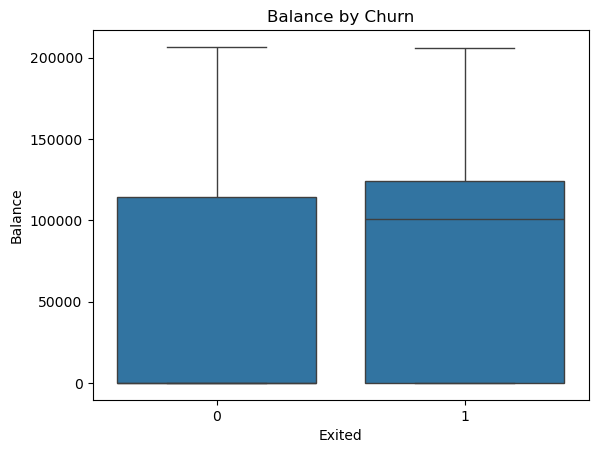

In [5]:
sns.boxplot(x='Exited', y='Balance', data=train)
plt.title('Balance by Churn')
plt.show()

In [6]:
# Drop ID columns
train.drop(['CustomerId', 'Surname'], axis=1, inplace=True)
test.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

# Encode categorical variables
for col in ['Geography', 'Gender']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# Split into X and y
X_train = train.drop('Exited', axis=1)
y_train = train['Exited']

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test)


In [7]:
lr = LogisticRegression(max_iter=1000)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f'Logistic Regression ROC AUC: {lr_scores.mean():.4f} ± {lr_scores.std():.4f}')


Logistic Regression ROC AUC: 0.8200 ± 0.0078


In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='roc_auc')
print(f'Random Forest ROC AUC: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}')


Random Forest ROC AUC: 0.8750 ± 0.0067


In [9]:
svm = SVC(kernel='rbf', probability=True)
svm_scores = cross_val_score(svm, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f'SVM ROC AUC: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}')

SVM ROC AUC: 0.8605 ± 0.0084


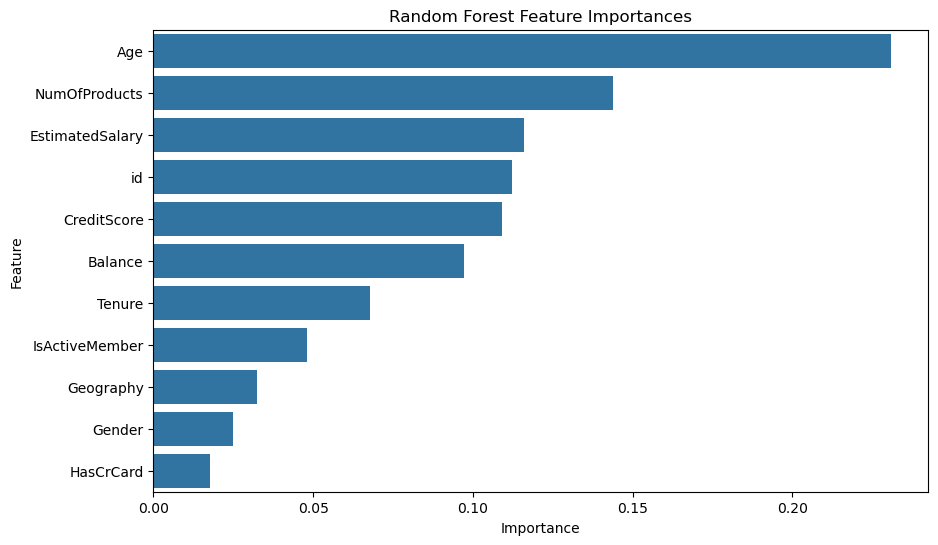

In [10]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_
features = X_train.columns
imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title('Random Forest Feature Importances')
plt.show()

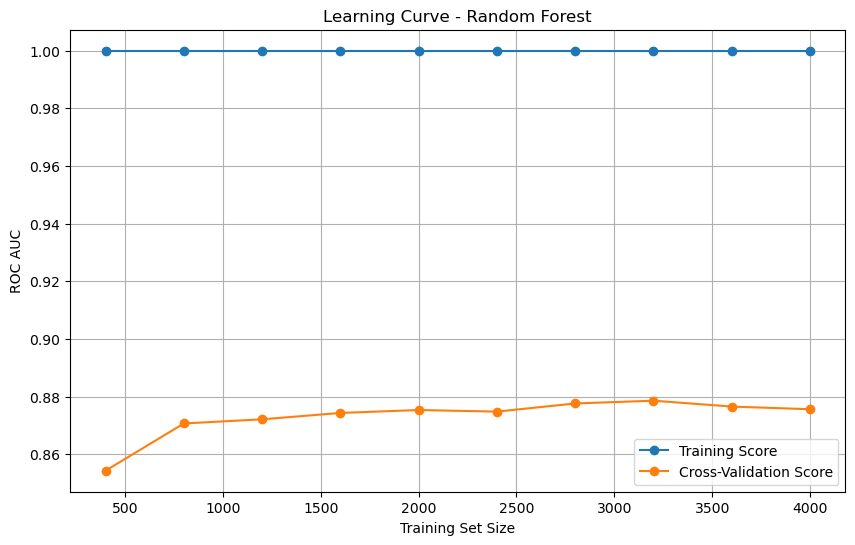

In [11]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve - Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.legend()
plt.show()


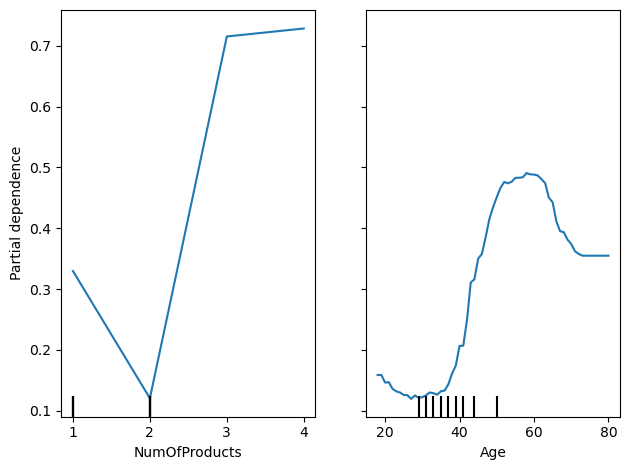

In [25]:
from sklearn.inspection import PartialDependenceDisplay

top_indices = rf.feature_importances_.argsort()[-2:]
top_features = [X_train.columns[i] for i in top_indices]

PartialDependenceDisplay.from_estimator(rf, X_train, features=top_features, kind='average')
plt.tight_layout()
plt.show()
